# Tutorial: Python Envrionment Management and EEG Processing with MNE

## Introduction

In this tutorial, we will explore how to manage Python environments effectively and process EEG data using the MNE library. 

This guide is designed for beginners who are new to Python environment management and EEG signal processing.

### Acknowledgements

This notebook is adapted from MNE [tutorial](https://mne.tools/stable/auto_examples/decoding/decoding_csp_eeg.html#sphx-glr-auto-examples-decoding-decoding-csp-eeg-py) and João Galego's [tutorial](https://github.com/JGalego/eeg-bci-tutorial).



### Packages

We will start by commonly used packages in machine learning and data analysis with Python in general:

* [Numpy](https://numpy.org) - *Fundamental package for scientific computing with Python*
* [Pandas](https://pandas.pydata.org) - *Powerful data structures for data analysis, time series, and statistics*
* [SciKit-Learn](https://scikit-learn.org/stable/index.html) - *Machine Learning in Python*
* [Matplotlib](https://matplotlib.org) - *Comprehensive library for creating static, animated, and interactive visualizations in Python*
* [Seaborn](https://seaborn.pydata.org) - *Statistical data visualization built on top of Matplotlib*

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


We will be using the [MNE](https://martinos.org/mne/) package extensively to analyze EEG data.

* [MNE](https://mne.tools/stable/index.html) - *Open-source Python software for exploring, visualizing, and analyzing human neurophysiological data: MEG, EEG, sEEG, ECoG, and more*

In [2]:
import mne

## Data

### EEGBCI Dataset

MNE provides easy access to some public [datasets](https://mne.tools/stable/overview/datasets_index.html).

In this tutorial, we will use the [EEG Motor Movement/Imagery Dataset
](https://physionet.org/content/eegmmidb/1.0.0/) (EEGBCI) dataset which is available at PhysioNet. 

This dataset contains <span style="color:red">**64-channel EEG**</span> recordings from <span style="color:red">**109 subjects**</span> and <span style="color:red">**14 runs**</span> on each subject in [EDF+](https://www.edfplus.info) format.

The recordings were made using the [BCI2000](https://en.wikipedia.org/wiki/BCI2000) system.

**Experimental Runs:**

1. Baseline, eyes open
2. Baseline, eyes closed
3. Task 1 (open and close left or right fist)
4. Task 2 (imagine opening and closing left or right fist)
5. Task 3 (open and close both fists or both feet)
6. Task 4 (imagine opening and closing both fists or both feet)
7. Task 1
8. Task 2
9. Task 3
10. Task 4
11. Task 1
12. Task 2
13. Task 3
14. Task 4

Each annotation includes one of three codes (`T0`, `T1`, or `T2`):

* `T0` corresponds to rest
* `T1` corresponds to onset of motion (real or imagined) of
    * the left fist (in runs 3, 4, 7, 8, 11, and 12)
    * both fists (in runs 5, 6, 9, 10, 13, and 14)
* `T2` corresponds to onset of motion (real or imagined) of
    * the right fist (in runs 3, 4, 7, 8, 11, and 12)
    * both feet (in runs 5, 6, 9, 10, 13, and 14)

We will use the [`eegbci.load_data`](https://mne.tools/stable/generated/mne.datasets.eegbci.load_data.html) funcion to fetch the data for the EEGBCI dataset and return the paths to local copies of EEGBCI dataset files.

In [3]:
from mne.datasets import eegbci

# Select subjects
subjects = [1]

# Select runs
runs = [6, 10, 14]  # motor imagery (hands vs feet)

raw_fnames = []
for subject in subjects:
    raw_fnames += eegbci.load_data(subject, runs)

### Loading Data

MNE stores continuous data in objects of type [`Raw`](https://mne.tools/dev/generated/mne.io.Raw.html). 

In essence, the `Raw` data structure is just a 2D numpy array (`channels × samples`, `._data`) combined with an [`Info`](https://mne.tools/dev/generated/mne.Info.html) object (`.info`). 

Information about the channels contained in the `Raw` object is contained in the `Info` attribute which behaves pretty much like a *dictionary*.

We will use the [`mne.read_raw_edf`](https://mne.tools/dev/generated/mne.io.read_raw_edf.html) function to convert the EDF files into raw objects (`RawEDF`) and join all objects into a single continuous one with [`concatenate_raws`](https://mne.tools/stable/generated/mne.concatenate_raws.html) function. Please notice that [MNE supports most standard file formats](https://mne.tools/dev/overview/implementation.html#supported-data-formats).

**Note:** if you're not using too much data, it's usually a good idea to preload the data into memory for easy manipulation and faster indexing

In [4]:
from mne import concatenate_raws
from mne.io import read_raw_edf

# Load data
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])

# Clean up channel names
raw.rename_channels(lambda x: x.strip('.'))

# Data is stored as a numpy array
print(type(raw._data))

# Metadata for the recording is available as an info object
print(raw.info)

# Check sample rate
print('sample rate:', raw.info['sfreq'], 'Hz')

# Gives the size of the data matrix
print('channels x samples:', raw._data.shape)

Extracting EDF parameters from /home/akgokce/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R06.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...


Extracting EDF parameters from /home/akgokce/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R10.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
Extracting EDF parameters from /home/akgokce/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R14.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 19999  =      0.000 ...   124.994 secs...
<class 'numpy.ndarray'>
<Info | 8 non-empty values
 bads: []
 ch_names: Fc5, Fc3, Fc1, Fcz, Fc2, Fc4, Fc6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
sample rate: 160.0 Hz
channels x samples: (64, 60000)


In MNE, the [typical EEG workflow](https://mne.tools/stable/overview/cookbook.html) always involves some kind of transformation on these `Raw`-type objects

<figure>
   <div align="center">
       <img src="https://mne.tools/stable/_images/flow_diagram.svg"/>
       <figcaption>
           <em>Workflow of the MNE software</em>
       </figcaption>
   </div>
</figure>

### Montage

In EEG parlance, **montage** means electrode placement.

In this notebook, we will use the `standard_1005` montage where electrodes are named and positioned according to the international **10-05 system** (343+3 locations).

In [5]:
from mne.channels import make_standard_montage

# Set channel names
eegbci.standardize(raw)
montage = make_standard_montage('standard_1005')
raw.set_montage(montage)
print(raw.info)

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 0.0 Hz
 lowpass: 80.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


### Temporal Filtering

Temporal filtering (also known as frequency or spectral filtering) is quintessential in improving the signal-to-noise (SNR) ratio in BCI systems. 

It can be used to (amongst other things):
* *remove low frequency signals* such as the ones related to EEG artifacts (eye blinks, amplifier drift or changes in skin resistance, &c.)
* *remove high frequency signals* such as the 50Hz (60Hz) noise from power sources
* *extract signal components* representing certain tasks e.g. motor imagery

Since we are working within the [motor imagery](https://en.wikipedia.org/wiki/Motor_imagery) paradigm, we will use a [band-pass filter](https://en.wikipedia.org/wiki/Band-pass_filter) to select the &#946; and &#956; bands

| Type  | Frequency (Hz) | Location                                                               | 
| :---: | :-------: | ---------------------------------------------------------------------- |
| &#948; (delta) | `0.1 - 4` | frontally in adults, posteriorly in children; <br>high amplitude waves |
| &#952; (theta) | `4 - 8` | found in locations unrelated to the task |
| &#945; (alpha) | `8 - 13` | posterior regions of the brain on both sides; <br> higher in amplitude on the non-dominant side; <br> central sites (`C3`, `C4`) at rest |
| &#956; (mu)    | `8 - 13` | sensorimotor cortex |
| &#946; (beta)  | `>13 - 30` | both sides, symmetrical distribution; <br> most evident frontally; <br> low amplitude waves |
| &#947; (gamma) | `30 - 100` | somatosensory cortex |

In [6]:
# Apply band-pass filter
raw.filter(7., 30., fir_design='firwin', skip_by_annotation="edge")

# Notice that the lowpass and highpass values have changed
print(raw.info)

Filtering raw data in 3 contiguous segments
Setting up band-pass filter from 7 - 30 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 7.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 6.00 Hz)
- Upper passband edge: 30.00 Hz
- Upper transition bandwidth: 7.50 Hz (-6 dB cutoff frequency: 33.75 Hz)
- Filter length: 265 samples (1.656 s)

<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>


### Plotting

`Raw`-type objects also have some basic plotting capabilities

Using matplotlib as 2D backend.


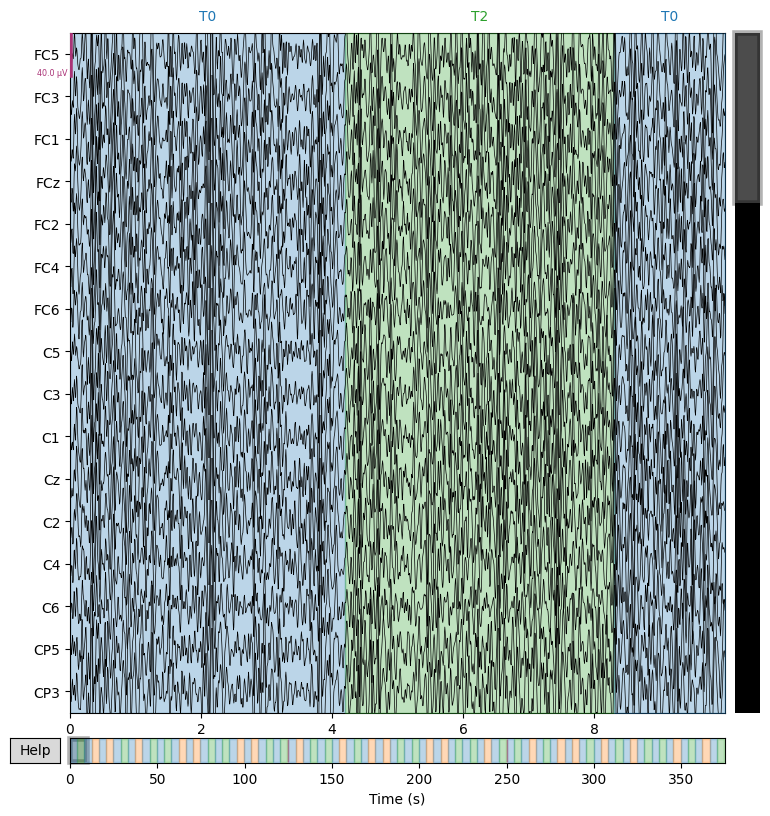

/tmp/ipykernel_20864/1436162754.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [7]:
fig = raw.plot(n_channels=16)
fig.show()

Plot sensor positions

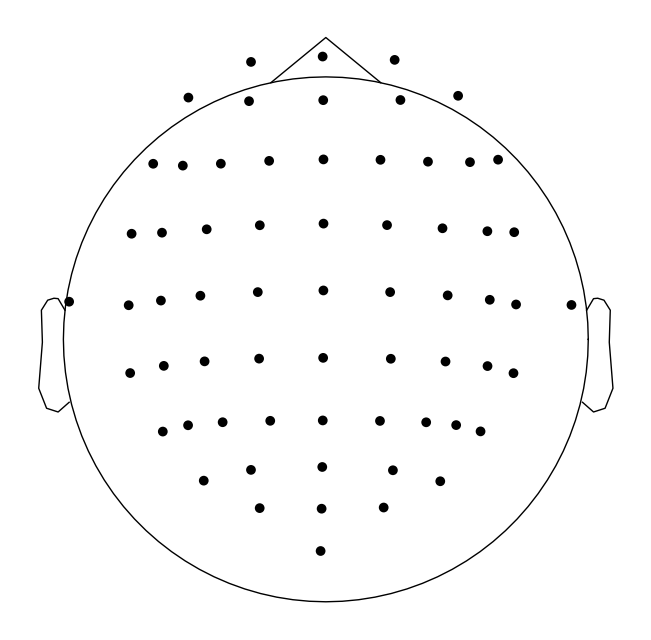

/tmp/ipykernel_20864/3979528213.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


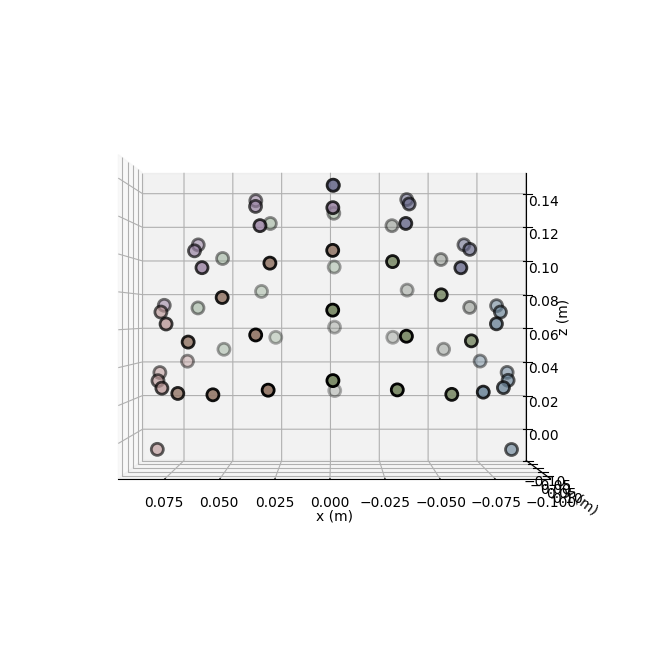

/tmp/ipykernel_20864/3979528213.py:5: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [8]:
fig = raw.plot_sensors(ch_type='eeg')
fig.show()

fig = raw.plot_sensors(kind='3d', ch_type='eeg', ch_groups='position')
fig.show()

Plot channel-wise frequency spectra as topography

Effective window size : 12.800 (s)


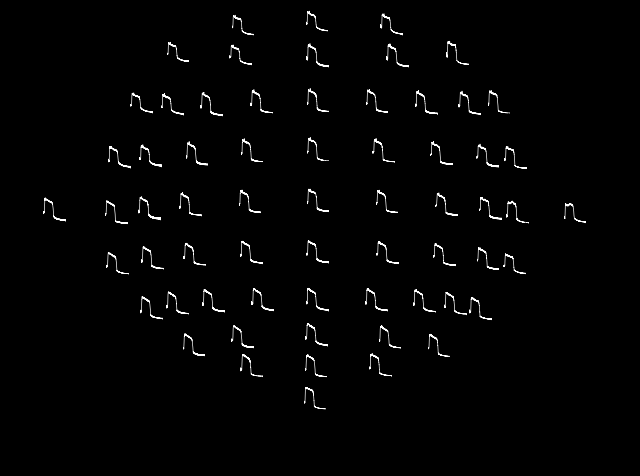

/tmp/ipykernel_20864/480647882.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [9]:
fig = raw.compute_psd().plot_topo()
fig.show()

### Channel Selection

For most BCI applications, we usually don't need **all** channels.

In [10]:
from mne import pick_types

# Select EEG channels
picks = pick_types(raw.info,
                   meg=False,
                   eeg=True,
                   stim=False,
                   eog=False,
                   )

### Epoching

[`Epochs`](https://mne.tools/dev/generated/mne.Epochs.html) objects are a way of representing continuous data as a *collection of time-locked trials*.

These are stored in an array of shape (`events x channels x samples`). 

They are useful for many statistical methods in neuroscience, and make it easy to get a sense of what's happening during a trial.

In [11]:
from mne import Epochs, events_from_annotations

# Avoid classification of evoked responses by using epochs that start 1s after cue onset
tmin, tmax = -1.0, 4.0


# Get events from an Annotations object.
event_id=dict(hands=2, feet=3)
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
print('Found {} events'.format(events.shape[0]))


# Read epochs
epochs = Epochs(raw,
                events=events,
                event_id=event_id,
                tmin=tmin,
                tmax=tmax,
                proj=True,
                picks=picks,
                baseline=None,
                preload=True
                )

# Inspect epochs
print(epochs.info)
print('events x channels x samples:', epochs._data.shape)

# Get labels
labels = epochs.events[:, -1] - 2

Used Annotations descriptions: [np.str_('T1'), np.str_('T2')]
Found 45 events
Not setting metadata


45 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 45 events and 801 original time points ...
0 bad epochs dropped
<Info | 9 non-empty values
 bads: []
 ch_names: FC5, FC3, FC1, FCz, FC2, FC4, FC6, C5, C3, C1, Cz, C2, C4, C6, ...
 chs: 64 EEG
 custom_ref_applied: False
 dig: 67 items (3 Cardinal, 64 EEG)
 highpass: 7.0 Hz
 lowpass: 30.0 Hz
 meas_date: 2009-08-12 16:15:00 UTC
 nchan: 64
 projs: []
 sfreq: 160.0 Hz
 subject_info: <subject_info | his_id: X, sex: 0, last_name: X>
>
events x channels x samples: (45, 64, 801)


In [12]:
epochs_data = epochs.get_data()
epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2

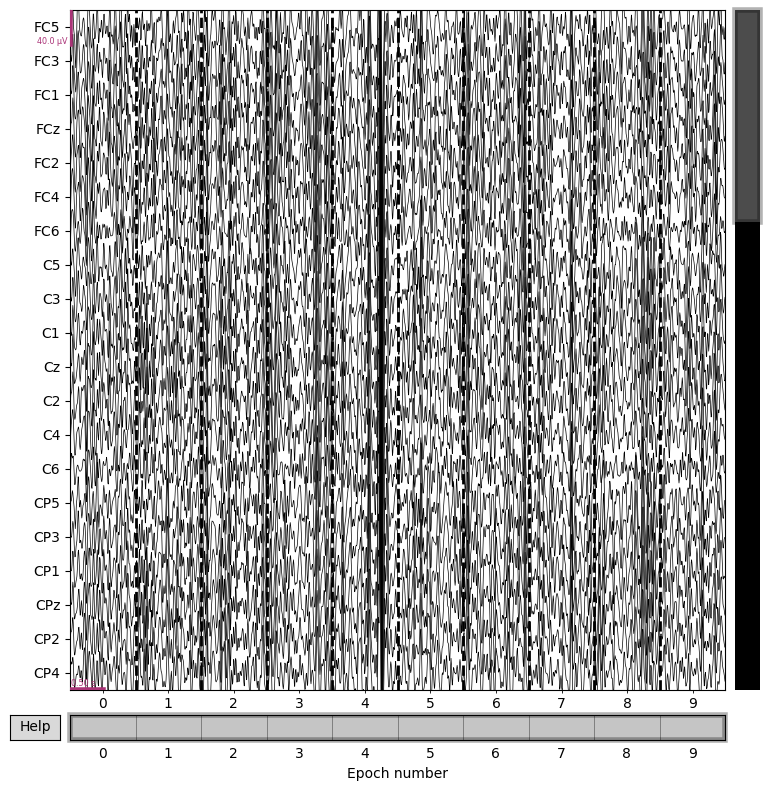

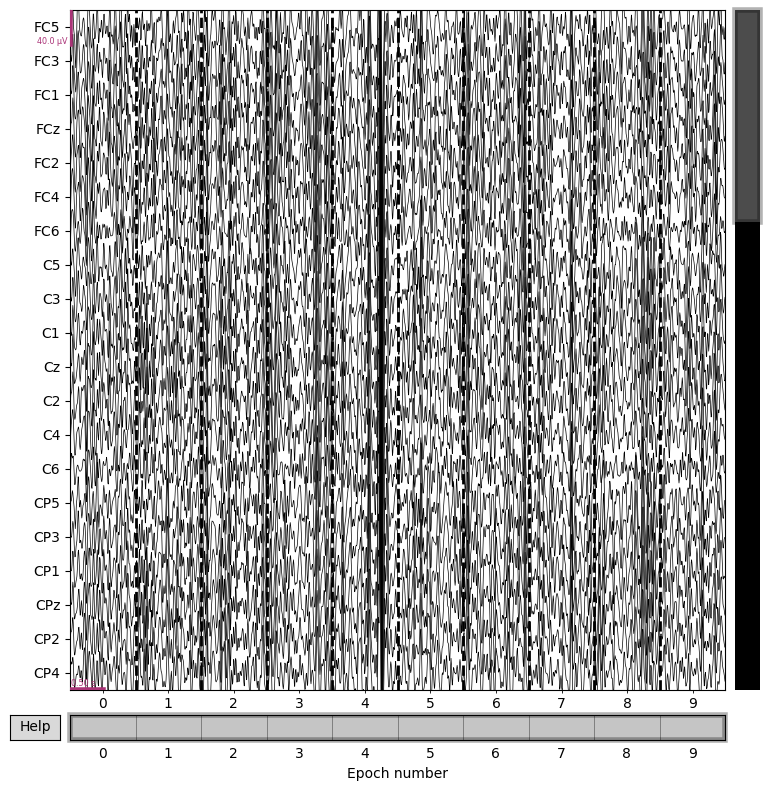

In [13]:
epochs_train[0:10].plot()

### Classification

#### Linear Discriminant Analysis

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_val_score, ShuffleSplit

from mne.decoding import CSP



# Define a monte-carlo cross-validation generator (reduce variance):
scores = []
epochs_data = epochs.get_data(copy=False)
epochs_data_train = epochs_train.get_data(copy=False)
cv = ShuffleSplit(10, test_size=0.2, random_state=42)
cv_split = cv.split(epochs_data_train)

# Assemble a classifier
lda = LinearDiscriminantAnalysis()
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# Use scikit-learn Pipeline with cross_val_score function
clf = Pipeline([("CSP", csp), ("LDA", lda)])
scores = cross_val_score(clf, epochs_data_train, labels, cv=cv, n_jobs=None)

Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 9.8e+09  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIR

Print the results

In [15]:
class_balance = np.mean(labels == labels[0])
class_balance = max(class_balance, 1. - class_balance)
print("CSP + LDA Classification accuracy: %f / Chance level: %f" 
                                  % (np.mean(scores), class_balance))

CSP + LDA Classification accuracy: 0.933333 / Chance level: 0.533333


Fit epochs data

In [16]:
%%capture
output = csp.fit_transform(epochs_data, labels)

Plot CSP patterns estimated on full data for visualization

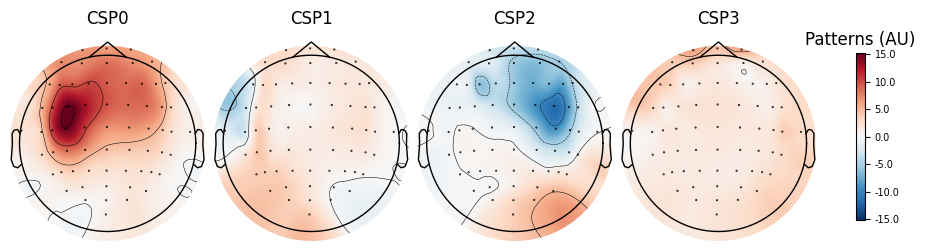

/tmp/ipykernel_20864/3580402808.py:2: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


In [17]:
fig = csp.plot_patterns(epochs.info, ch_type='eeg', units='Patterns (AU)', size=1.5)
fig.show()

Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00014 (2.2e-16 eps * 64 dim * 9.8e+09  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIRICAL
Done.
Estimating class=1 covariance using EMPIRICAL
Done.
Computing rank from data with rank=None
    Using tolerance 0.00016 (2.2e-16 eps * 64 dim * 1.1e+10  max singular value)
    Estimated rank (data): 64
    data: rank 64 computed from 64 data channels with 0 projectors
Reducing data rank from 64 -> 64
Estimating class=0 covariance using EMPIR

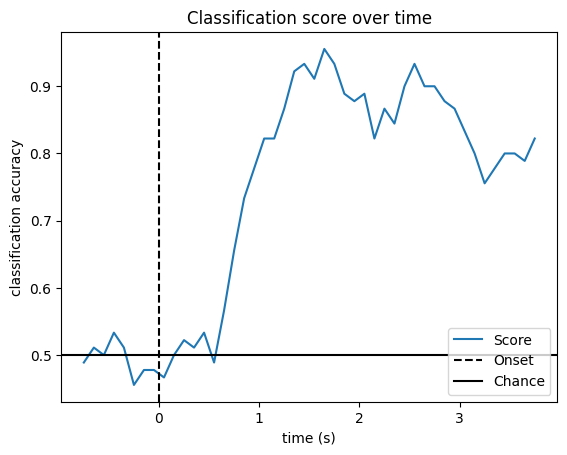

In [18]:
sfreq = raw.info["sfreq"]
w_length = int(sfreq * 0.5)  # running classifier: window length
w_step = int(sfreq * 0.1)  # running classifier: window step size
w_start = np.arange(0, epochs_data.shape[2] - w_length, w_step)

scores_windows = []

for train_idx, test_idx in cv_split:
    y_train, y_test = labels[train_idx], labels[test_idx]

    X_train = csp.fit_transform(epochs_data_train[train_idx], y_train)
    X_test = csp.transform(epochs_data_train[test_idx])

    # fit classifier
    lda.fit(X_train, y_train)

    # running classifier: test classifier on sliding window
    score_this_window = []
    for n in w_start:
        X_test = csp.transform(epochs_data[test_idx][:, :, n : (n + w_length)])
        score_this_window.append(lda.score(X_test, y_test))
    scores_windows.append(score_this_window)

# Plot scores over time
w_times = (w_start + w_length / 2.0) / sfreq + epochs.tmin

plt.figure()
plt.plot(w_times, np.mean(scores_windows, 0), label="Score")
plt.axvline(0, linestyle="--", color="k", label="Onset")
plt.axhline(0.5, linestyle="-", color="k", label="Chance")
plt.xlabel("time (s)")
plt.ylabel("classification accuracy")
plt.title("Classification score over time")
plt.legend(loc="lower right")
plt.show()

In [22]:
X_train.shape
X_test.shape

(9, 4)

In [23]:
epochs_data_train[train_idx].shape

(36, 64, 161)